# MB_molec

In [196]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [197]:
import seaborn as sns
sns.set()

In [198]:
df = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/3way/mb_t1_t2_3way.xlsx")

In [199]:
reduced_features = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/3way/3way_reduced.xlsx")

In [200]:
reduced_features_list = reduced_features.loc[reduced_features['coeff1'].isnull() == False, ['coeff1']].values.tolist()

In [201]:
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [202]:
reduced_features_list

['t1_log-sigma-1-mm-3D_glcm_MCC',
 't1_wavelet-LHL_glcm_Idmn',
 't1_log-sigma-1-mm-3D_glcm_Correlation',
 't1_log-sigma-3-mm-3D_glszm_ZoneEntropy',
 't1_log-sigma-1-mm-3D_glcm_Imc2',
 't2_wavelet-LHL_glcm_Correlation']

In [203]:
target = df["molecular"]

In [204]:
target.value_counts()

group3    154
shh        83
wnt        26
Name: molecular, dtype: int64

In [205]:
#Marking 0 as wnt and shh as pilo and 2 as other
mapping_dict = {0: 'wnt', 1: 'shh', 2: 'group3'} ##
target = target.map(dict(wnt = 0, shh = 1, group3 = 2)) ##

In [206]:
target.value_counts()

2    154
1     83
0     26
Name: molecular, dtype: int64

In [207]:
features_after_lasso = df[reduced_features_list]

In [208]:
#sex_binarized = features_after_lasso['sex'].map(dict(M = 1, F = 0)).to_numpy()

#features_after_lasso['sex'] = sex_binarized

In [209]:
features_after_lasso 

,t1_log-sigma-1-mm-3D_glcm_MCC,t1_wavelet-LHL_glcm_Idmn,t1_log-sigma-1-mm-3D_glcm_Correlation,t1_log-sigma-3-mm-3D_glszm_ZoneEntropy,t1_log-sigma-1-mm-3D_glcm_Imc2,t2_wavelet-LHL_glcm_Correlation
0,0.562873,0.991128,0.505918,6.085980,0.598074,0.103778
1,0.475984,0.992618,0.432892,3.452820,0.526313,0.061382
2,0.534334,0.986307,0.507732,5.734016,0.595173,0.174619
3,0.506549,0.986591,0.469566,4.680813,0.540765,0.127705
4,0.591460,0.995139,0.577000,6.403898,0.688192,0.059942
...,...,...,...,...,...,...
258,0.442936,0.987602,0.435700,5.965791,0.535725,0.015260
259,0.607139,0.984527,0.593270,6.756336,0.711376,0.114800
260,0.549441,0.992312,0.545969,7.430941,0.651596,0.085276
261,0.653609,0.993674,0.649351,6.837161,0.759131,0.242218


In [210]:
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)

In [211]:
y_train.value_counts()

2    112
1     69
0     16
Name: molecular, dtype: int64

In [212]:
y_test.value_counts()

2    42
1    14
0    10
Name: molecular, dtype: int64

# Principal Components Analysis - [Removed]

# Resampling to correct for imbalance

In [213]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['molecular'] == 0] ## wnt
X_1 = X[X['molecular'] == 1] ## shh
X_2 = X[X['molecular'] == 2] ## group3 is highest

In [214]:
len(X_2)

112

In [215]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_2), random_state = 42)
upsampled_1 = resample(X_1, replace = True, n_samples = len(X_2), random_state = 42)
upsampled = pd.concat([upsampled_0, upsampled_1, X_2])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [216]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

In [217]:
y_train.value_counts()

2    112
1    112
0    112
Name: molecular, dtype: int64

In [218]:
y_train_bin = label_binarize(y_train, classes = [0, 1, 2])
y_test_bin = label_binarize(y_test, classes = [0, 1, 2])

# Standardizing Features

In [219]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [220]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [221]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

In [222]:
def specificity_score(y_pred, y_true):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [223]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [224]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [225]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.3f} - {:0.3}]".format(name, i,
        confidence_lower, confidence_upper))

In [226]:
def my_classification_report(y_test_np, y_pred):

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    spec_arr = []
    ppv_arr = [] ##
    npv_arr = [] ##
    rec_arr = []
    acc_arr = [] 

    print("Specificities")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TN += TN
        tot_FP += FP
        spec_arr.append(TN/(TN+FP))
        print(group, spec_arr[group])

    print("Macro Avg : " + str(np.array(spec_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("PPV/Precision") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TP += TP
        tot_FP += FP
        ppv_arr.append(TP/(TP+FP))
        print(group, ppv_arr[group])
    
    print("Macro Avg : " + str(np.array(ppv_arr).mean()))
    prec_for_mic_f1 = tot_TP / (tot_TP + tot_FP)
    print("Micro Avg : " + str(prec_for_mic_f1), '\n')

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("NPV") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TN += TN
        tot_FN += FN
        npv_arr.append(TN/(TN+FN))
        print(group, npv_arr[group])
    
    print("Macro Avg : " + str(np.array(npv_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN)), '\n') 
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Recall") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TP += TP
        tot_FN += FN
        rec_arr.append(TP/(TP+FN))
        print(group, rec_arr[group])
    
    print("Macro Avg : " + str(np.array(rec_arr).mean()))
    rec_for_mic_f1 = tot_TP / (tot_TP + tot_FN)
    print("Micro Avg : " + str(rec_for_mic_f1), '\n')
    
    print("F1 Score") ##
    for group in range(3):
        print(group, 2 * (rec_arr[group] * ppv_arr[group]) / (rec_arr[group] + ppv_arr[group]))
    print("Macro Avg : " + str(2 * (np.array(rec_arr).mean() * np.array(ppv_arr).mean()) 
                               / (np.array(rec_arr).mean() + np.array(ppv_arr).mean())))
    print("Micro Avg : " + str(2 * (prec_for_mic_f1 * rec_for_mic_f1)/ (prec_for_mic_f1 + rec_for_mic_f1)), '\n')
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Accuracy:")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        
        tot_TP += TP
        tot_TN += TN
        tot_FP += FP
        tot_FN += FN
        
        acc_arr.append((TP + TN)/(TP + TN + FP + FN))
        print(group, acc_arr[group])
        #print("TP:" + str(TP))
        #print("TN:" + str(TN))
        #print("FP:" + str(FP))
        #print("FN:" + str(FN))
        
        #print(TP + TN)
        #print(TP + TN + FP + FN, '\n')
        
    #print("Total TP:" + str(tot_TP))
    #print("Total TN:" + str(tot_TN))
    #print("Total FP:" + str(tot_FP))
    #print("Total FN:" + str(tot_FN), '\n')

    print("Macro Avg : " + str(np.array(acc_arr).mean()))
    print("Micro Avg : " + str((tot_TP + tot_TN)/(tot_TP + tot_TN + tot_FP + tot_FN)), '\n') ##

# SVM

### Grid Search for Hyperparameters

In [227]:
svm_model = OneVsRestClassifier(svm.SVC())

In [228]:
grid_param = {'estimator__C': [0.1, 1, 10],
              'estimator__gamma': [1, 0.1, 0.01]
}


svm_grid = GridSearchCV(estimator=svm_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [229]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=SVC()), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__gamma': [1, 0.1, 0.01]},
             scoring='accuracy')

In [230]:
print(svm_grid.best_params_)

{'estimator__C': 10, 'estimator__gamma': 1}


### Model Performance

In [231]:
svm_model = OneVsRestClassifier(svm.SVC(C = 10, gamma = 0.01, probability = True))
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [232]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.7678571428571429
1 0.5192307692307693
2 0.9166666666666666
Macro Avg : 0.7345848595848596
Micro Avg : 0.696969696969697 

PPV/Precision
0 0.3157894736842105
1 0.34210526315789475
2 0.7777777777777778
Macro Avg : 0.47855750487329435
Micro Avg : 0.3939393939393939 

NPV
0 0.9148936170212766
1 0.9642857142857143
2 0.38596491228070173
Macro Avg : 0.7550480811958975
Micro Avg : 0.696969696969697 

Recall
0 0.6
1 0.9285714285714286
2 0.16666666666666666
Macro Avg : 0.5650793650793651
Micro Avg : 0.3939393939393939 

F1 Score
0 0.41379310344827586
1 0.5
2 0.2745098039215686
Macro Avg : 0.5182319229868393
Micro Avg : 0.3939393939393939 

Accuracy:
0 0.7424242424242424
1 0.6060606060606061
2 0.4393939393939394
Macro Avg : 0.595959595959596
Micro Avg : 0.5959595959595959 



In [233]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.60      0.41        10
           1       0.34      0.93      0.50        14
           2       0.78      0.17      0.27        42

    accuracy                           0.39        66
   macro avg       0.48      0.57      0.40        66
weighted avg       0.62      0.39      0.34        66



In [234]:
n_classes = 3 ##
svm_model_for_auc = OneVsRestClassifier(svm.SVC(C = 10, gamma = 0.01, probability = True))
y_score = svm_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = svm_model_for_auc.predict(X_test)

wnt
Accuracy: 0.8787878787878788
shh
Accuracy: 0.7424242424242424
group3
Accuracy: 0.36363636363636365
Micro-Averaged AUC: 0.6511707988980716


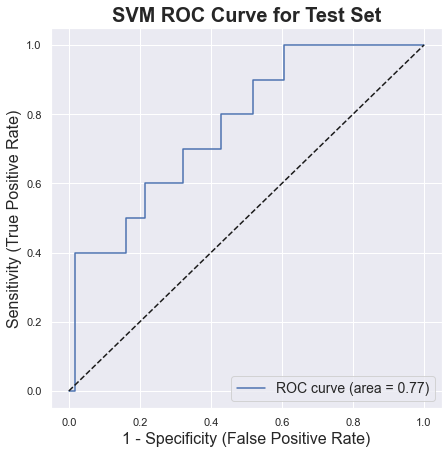

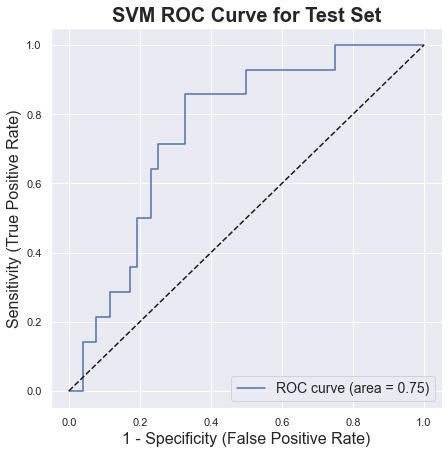

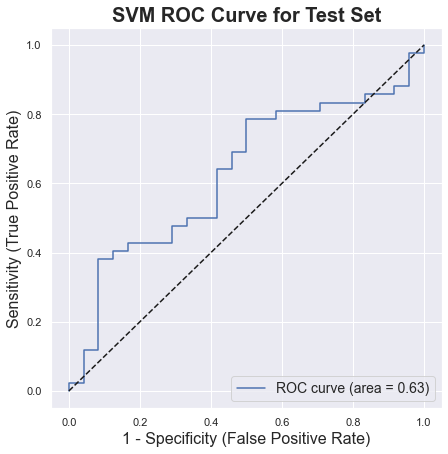

In [235]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))



# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('SVM ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()


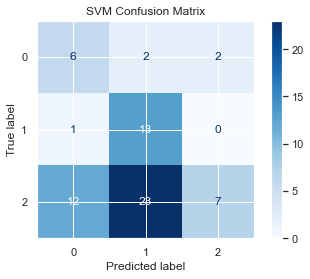

In [236]:
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show(matrix)
plt.show()

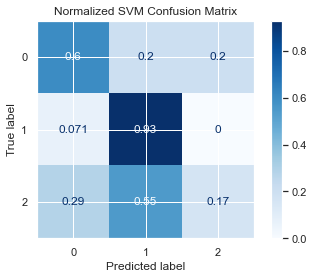

In [237]:
norm_matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized SVM Confusion Matrix')
plt.show(matrix)
plt.show()

In [238]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##

    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [239]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

# Logistic Regression

### Grid Search for Hyperparameters

In [240]:
lr_model = OneVsRestClassifier(LogisticRegression())
grid_param = {'estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'estimator__C': [10, 1, 0.1, 0.01, 0.001]
}

lr_grid = GridSearchCV(estimator=lr_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [241]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [10, 1, 0.1, 0.01, 0.001],
                         'estimator__penalty': ['l1', 'l2', 'elasticnet',
                                                'none']},
             scoring='accuracy')

In [242]:
print(lr_grid.best_params_)

{'estimator__C': 1, 'estimator__penalty': 'l2'}


### Model Performance

In [243]:
lr_model = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 1))
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [244]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.7857142857142857
1 0.6153846153846154
2 0.75
Macro Avg : 0.717032967032967
Micro Avg : 0.7121212121212122 

PPV/Precision
0 0.29411764705882354
1 0.3548387096774194
2 0.6666666666666666
Macro Avg : 0.4385410078009698
Micro Avg : 0.42424242424242425 

NPV
0 0.8979591836734694
1 0.9142857142857143
2 0.375
Macro Avg : 0.7290816326530613
Micro Avg : 0.7121212121212122 

Recall
0 0.5
1 0.7857142857142857
2 0.2857142857142857
Macro Avg : 0.5238095238095237
Micro Avg : 0.42424242424242425 

F1 Score
0 0.37037037037037035
1 0.48888888888888893
2 0.4
Macro Avg : 0.47739768186702547
Micro Avg : 0.4242424242424243 

Accuracy:
0 0.7424242424242424
1 0.6515151515151515
2 0.45454545454545453
Macro Avg : 0.6161616161616162
Micro Avg : 0.6161616161616161 



In [245]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.50      0.37        10
           1       0.35      0.79      0.49        14
           2       0.67      0.29      0.40        42

    accuracy                           0.42        66
   macro avg       0.44      0.52      0.42        66
weighted avg       0.54      0.42      0.41        66



In [246]:
n_classes = 3
lr_model_for_auc = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 1, random_state = 42))
y_score = lr_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = lr_model_for_auc.predict(X_test)

wnt
Accuracy: 0.8333333333333334
shh
Accuracy: 0.7121212121212122
group3
Accuracy: 0.36363636363636365
Micro-Averaged ROC: 0.6937557392102847


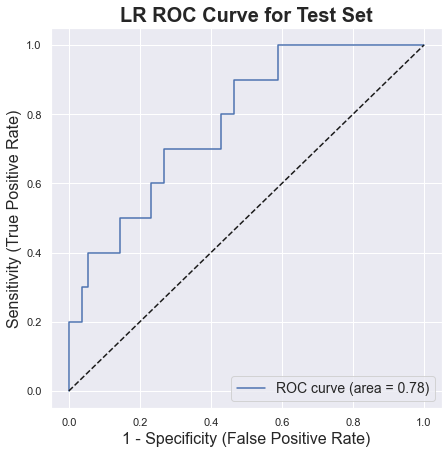

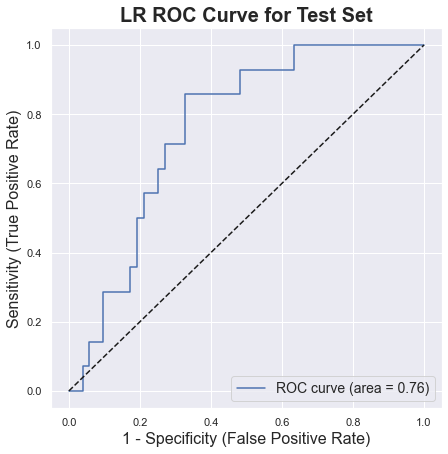

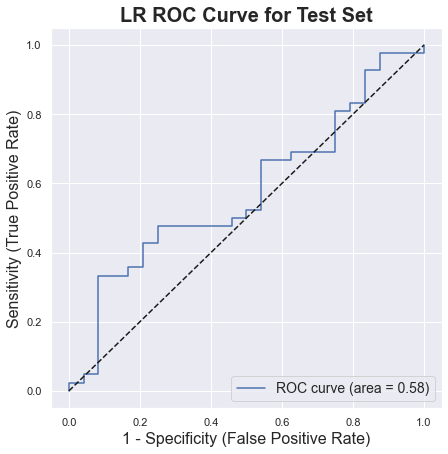

In [247]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged ROC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('LR ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

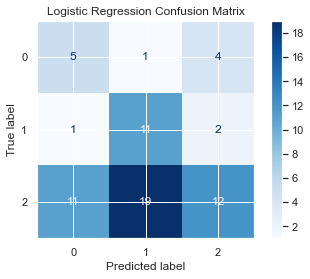

In [248]:
matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

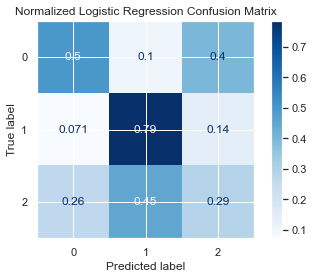

In [249]:
norm_matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

In [250]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [251]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

Feature: 0, Score: 0.17660
Feature: 1, Score: -0.60886
Feature: 2, Score: -0.24375
Feature: 3, Score: 0.20196
Feature: 4, Score: -0.79975
Feature: 5, Score: -0.14887


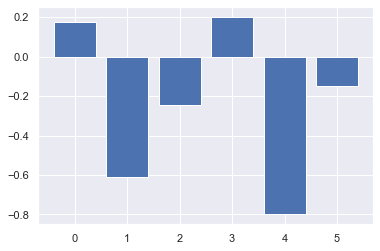

In [252]:
importance = lr_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

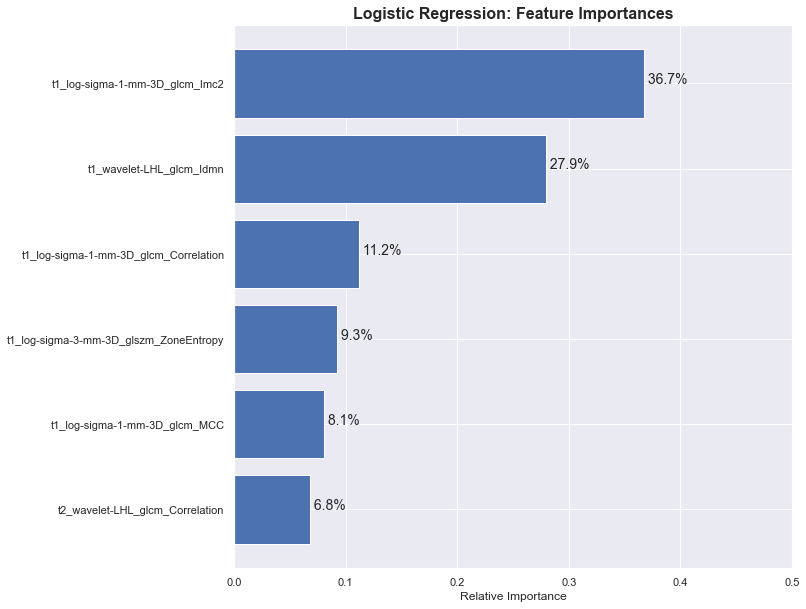

In [253]:
feature_names = X_test.columns.to_list()
importance = lr_model.coef_[0]
importance = np.abs(importance) / np.sum(np.abs(importance))
indices = np.argsort(importance)

plt.figure(figsize=(10, 10)) ##
plt.title('Logistic Regression: Feature Importances', fontsize=16, fontweight='semibold') ##
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.xlim(0, 0.50) ##
for index, value in enumerate(importance[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

# KNN

### Grid Search for Hyperparameters

In [254]:
knn_model = KNeighborsClassifier()
grid_param = {'n_neighbors': [3, 5, 7]
}

knn_grid = GridSearchCV(estimator=knn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [255]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7]}, scoring='accuracy')

In [256]:
print(knn_grid.best_params_)

{'n_neighbors': 3}


### Model Performance

In [257]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [258]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.9464285714285714
1 0.5384615384615384
2 0.5416666666666666
Macro Avg : 0.6755189255189255
Micro Avg : 0.7121212121212122 

PPV/Precision
0 0.5
1 0.25
2 0.6071428571428571
Macro Avg : 0.4523809523809524
Micro Avg : 0.42424242424242425 

NPV
0 0.8833333333333333
1 0.8235294117647058
2 0.34210526315789475
Macro Avg : 0.6829893360853113
Micro Avg : 0.7121212121212122 

Recall
0 0.3
1 0.5714285714285714
2 0.40476190476190477
Macro Avg : 0.4253968253968254
Micro Avg : 0.42424242424242425 

F1 Score
0 0.37499999999999994
1 0.34782608695652173
2 0.4857142857142857
Macro Avg : 0.4384741238267459
Micro Avg : 0.4242424242424243 

Accuracy:
0 0.8484848484848485
1 0.5454545454545454
2 0.45454545454545453
Macro Avg : 0.6161616161616162
Micro Avg : 0.6161616161616161 



In [259]:
print(classification_report(y_test, y_pred))
##not a direct classifier

              precision    recall  f1-score   support

           0       0.50      0.30      0.37        10
           1       0.25      0.57      0.35        14
           2       0.61      0.40      0.49        42

    accuracy                           0.42        66
   macro avg       0.45      0.43      0.40        66
weighted avg       0.52      0.42      0.44        66



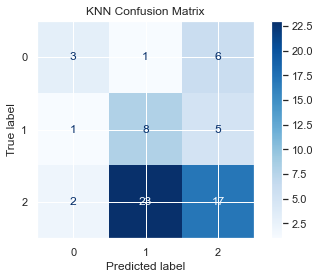

In [260]:
matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show(matrix)
plt.show()

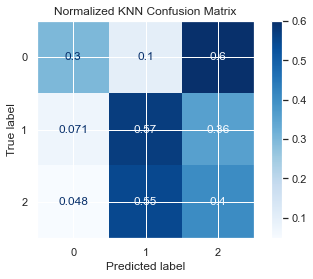

In [261]:
norm_matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized KNN Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8484848484848485
shh
Accuracy: 0.5454545454545454
group3
Accuracy: 0.45454545454545453
Micro-Averaged AUC: 0.6056014692378329


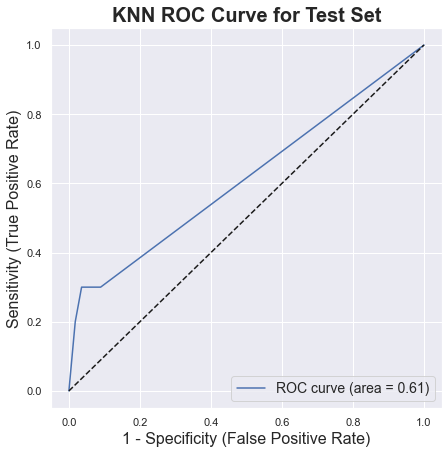

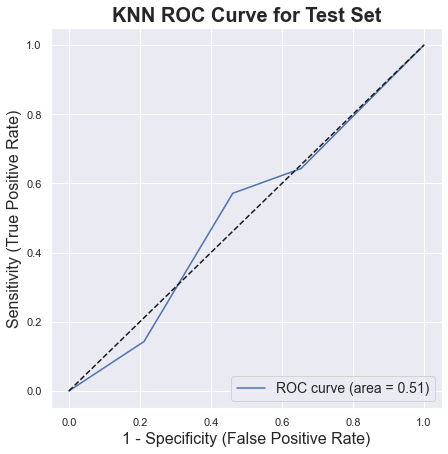

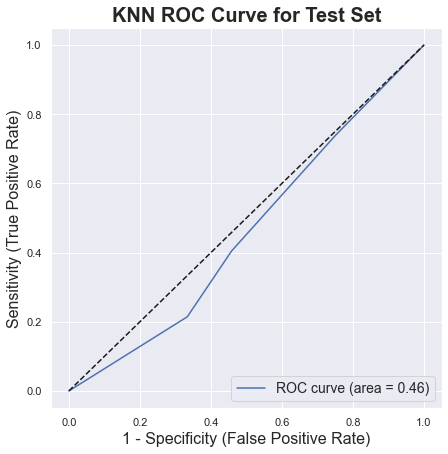

In [262]:
y_score = knn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3])##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('KNN ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [263]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [264]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

# Random Forest

### Grid Search for Hyperparameters
 

In [265]:
rf_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_grid = GridSearchCV(estimator=rf_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [266]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [267]:
print(rf_grid.best_params_)

{'max_depth': 4, 'n_estimators': 50}


### Model Performance

In [268]:
rf_model = RandomForestClassifier(max_depth = 4, n_estimators = 50, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [269]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.32      0.86      0.47        14
           2       0.71      0.40      0.52        42

    accuracy                           0.48        66
   macro avg       0.54      0.52      0.46        66
weighted avg       0.61      0.48      0.49        66



In [270]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.9642857142857143
1 0.5192307692307693
2 0.7083333333333334
Macro Avg : 0.7306166056166057
Micro Avg : 0.7424242424242424 

PPV/Precision
0 0.6
1 0.32432432432432434
2 0.7083333333333334
Macro Avg : 0.5442192192192192
Micro Avg : 0.48484848484848486 

NPV
0 0.8852459016393442
1 0.9310344827586207
2 0.40476190476190477
Macro Avg : 0.7403474297199565
Micro Avg : 0.7424242424242424 

Recall
0 0.3
1 0.8571428571428571
2 0.40476190476190477
Macro Avg : 0.5206349206349206
Micro Avg : 0.48484848484848486 

F1 Score
0 0.4
1 0.4705882352941177
2 0.5151515151515152
Macro Avg : 0.5321658984112276
Micro Avg : 0.48484848484848486 

Accuracy:
0 0.8636363636363636
1 0.5909090909090909
2 0.5151515151515151
Macro Avg : 0.6565656565656566
Micro Avg : 0.6565656565656566 



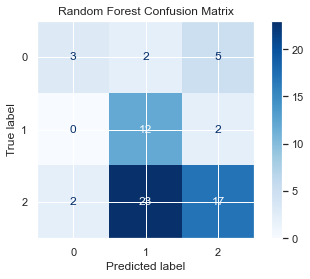

In [271]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

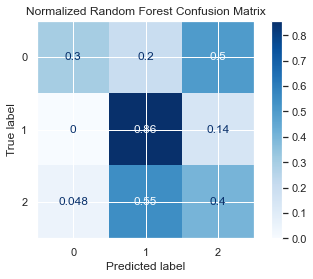

In [272]:
norm_matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8636363636363636
shh
Accuracy: 0.5909090909090909
group3
Accuracy: 0.5151515151515151
Micro-Averaged AUC: 0.7462121212121212


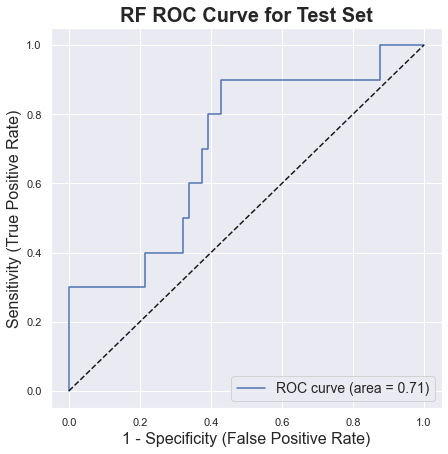

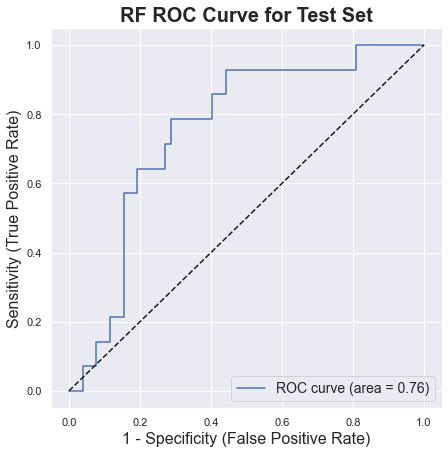

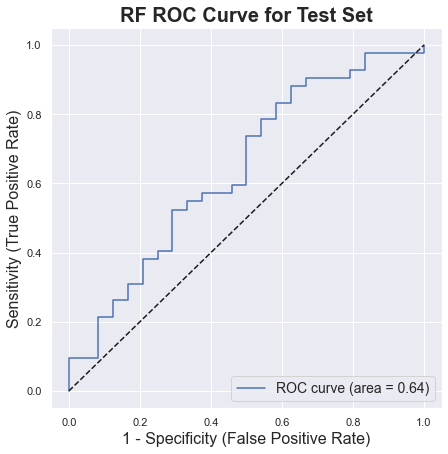

In [273]:
y_score = rf_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3]) ##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('RF ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [274]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] 
    one_npv = [] 
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [275]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

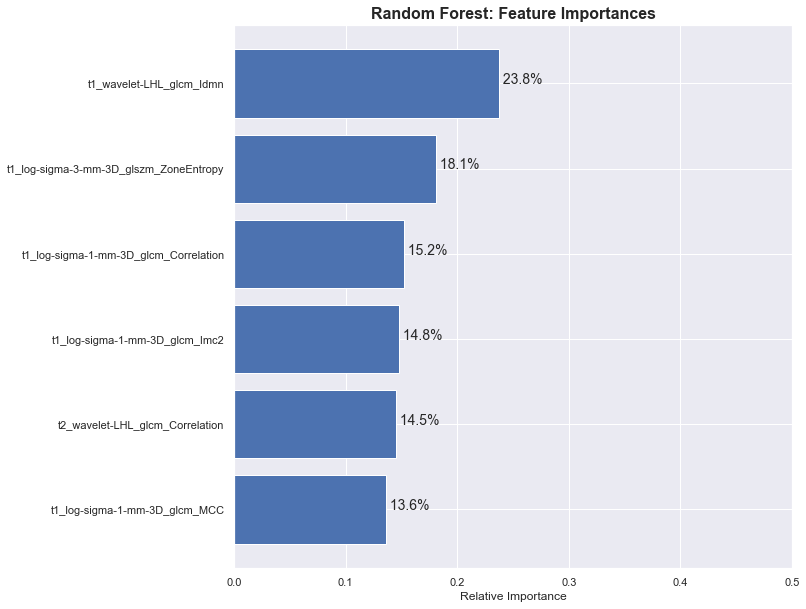

In [276]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 10)) ##
plt.title('Random Forest: Feature Importances', fontsize=16, fontweight='semibold') ##
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.50) ##
for index, value in enumerate(importances[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost

### Grid Search for Hyperparameters

In [277]:
xgb_model = XGBClassifier(objective = 'multi:softmax', random_state = 42)
grid_param = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

xgb_grid = GridSearchCV(estimator=xgb_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [278]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsampl

In [279]:
print(xgb_grid.best_params_)

{'learning_rate': 0.3, 'max_depth': 6}


### Model Performance

In [280]:
xgb_model = XGBClassifier(objective = 'multi:softmax', learning_rate = 0.3, max_depth = 6, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [281]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 1.0
1 0.6923076923076923
2 0.5416666666666666
Macro Avg : 0.7446581196581197
Micro Avg : 0.7954545454545454 

PPV/Precision
0 1.0
1 0.38461538461538464
2 0.7105263157894737
Macro Avg : 0.6983805668016195
Micro Avg : 0.5909090909090909 

NPV
0 0.875
1 0.9
2 0.4642857142857143
Macro Avg : 0.7464285714285714
Micro Avg : 0.7954545454545454 

Recall
0 0.2
1 0.7142857142857143
2 0.6428571428571429
Macro Avg : 0.5190476190476191
Micro Avg : 0.5909090909090909 

F1 Score
0 0.33333333333333337
1 0.5
2 0.6749999999999999
Macro Avg : 0.5955057959080257
Micro Avg : 0.5909090909090909 

Accuracy:
0 0.8787878787878788
1 0.696969696969697
2 0.6060606060606061
Macro Avg : 0.7272727272727272
Micro Avg : 0.7272727272727273 



In [282]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.38      0.71      0.50        14
           2       0.71      0.64      0.67        42

    accuracy                           0.59        66
   macro avg       0.70      0.52      0.50        66
weighted avg       0.69      0.59      0.59        66



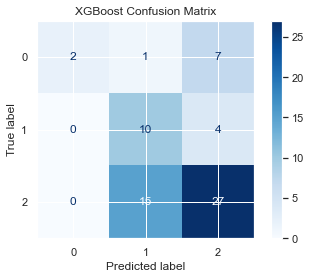

In [283]:
matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

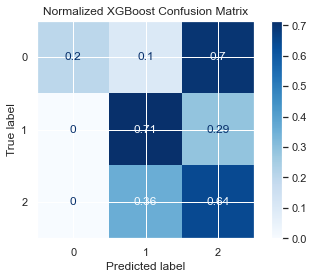

In [284]:
norm_matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8787878787878788
shh
Accuracy: 0.696969696969697
group3
Accuracy: 0.6060606060606061
Micro-Averaged AUC: 0.7388659320477503


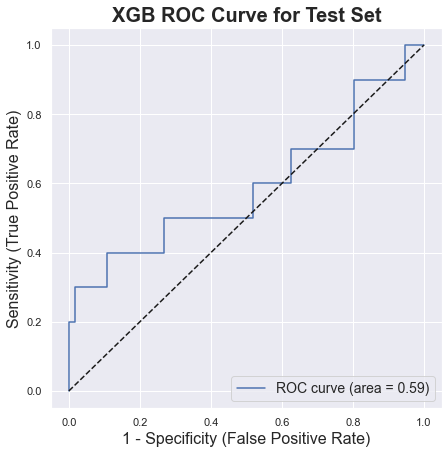

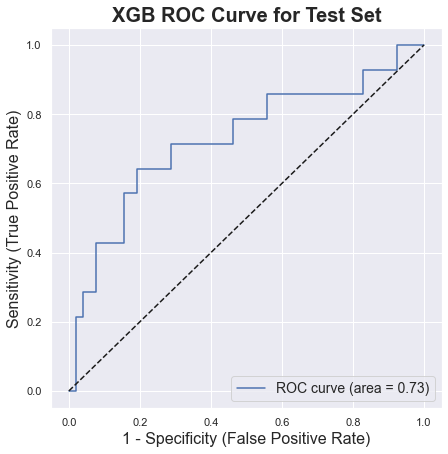

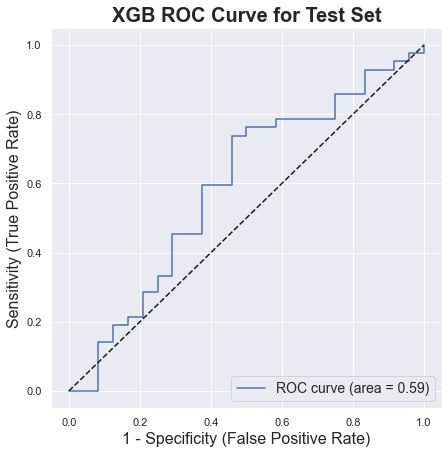

In [285]:
y_score = xgb_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3]) ##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('XGB ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [286]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [287]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

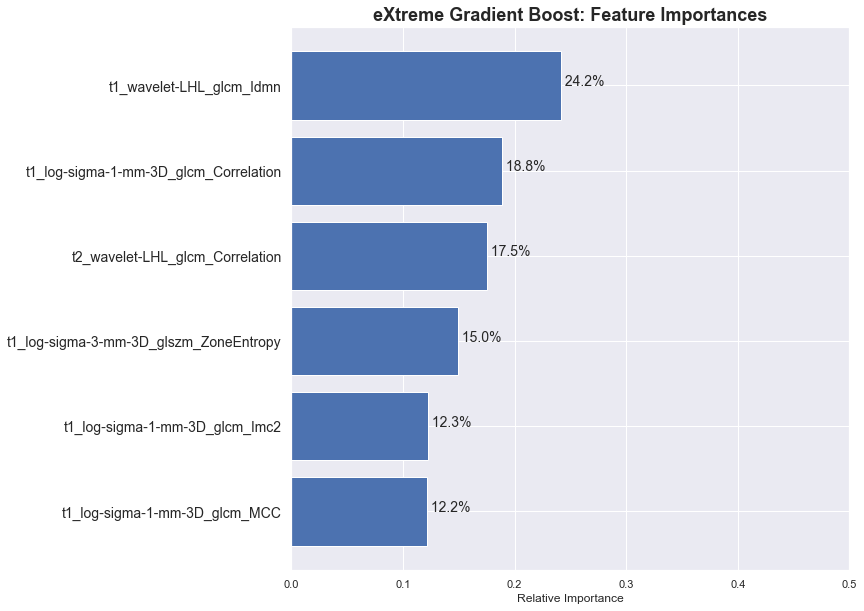

In [288]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 10)) ##
plt.title('eXtreme Gradient Boost: Feature Importances', fontsize=18, fontweight='semibold') ##
plt.xlim(0, 0.50) ##
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
for index, value in enumerate(importances[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14)
plt.xlabel('Relative Importance')

plt.show()

# Neural Net

### Grid Search for Hyperparameters

In [289]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_grid = GridSearchCV(estimator=nn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [290]:
nn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [291]:
print(nn_grid.best_params_)

{'hidden_layer_sizes': (100, 50, 100), 'learning_rate': 'constant'}


### Model Performance

In [292]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 50, 100), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [293]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.9821428571428571
1 0.7307692307692307
2 0.4166666666666667
Macro Avg : 0.7098595848595849
Micro Avg : 0.7803030303030303 

PPV/Precision
0 0.75
1 0.3333333333333333
2 0.6585365853658537
Macro Avg : 0.5806233062330622
Micro Avg : 0.5606060606060606 

NPV
0 0.8870967741935484
1 0.8444444444444444
2 0.4
Macro Avg : 0.7105137395459976
Micro Avg : 0.7803030303030303 

Recall
0 0.3
1 0.5
2 0.6428571428571429
Macro Avg : 0.480952380952381
Micro Avg : 0.5606060606060606 

F1 Score
0 0.4285714285714285
1 0.4
2 0.6506024096385543
Macro Avg : 0.5261088115339497
Micro Avg : 0.5606060606060606 

Accuracy:
0 0.8787878787878788
1 0.6818181818181818
2 0.5606060606060606
Macro Avg : 0.7070707070707071
Micro Avg : 0.7070707070707071 



In [294]:
print(classification_report(y_test, y_pred))
##not a direct classifier

              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.33      0.50      0.40        14
           2       0.66      0.64      0.65        42

    accuracy                           0.56        66
   macro avg       0.58      0.48      0.49        66
weighted avg       0.60      0.56      0.56        66



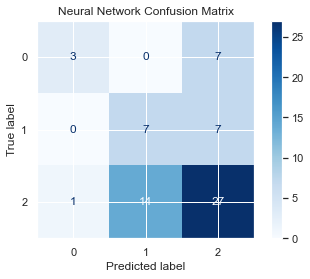

In [295]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

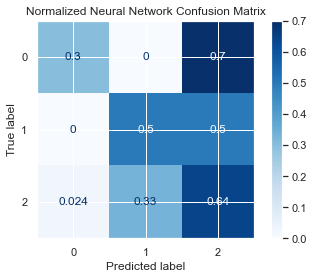

In [296]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8787878787878788
shh
Accuracy: 0.6818181818181818
group3
Accuracy: 0.5606060606060606
Micro-Averaged AUC: 0.7545913682277319


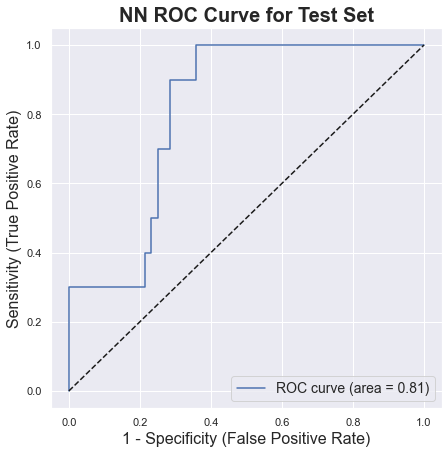

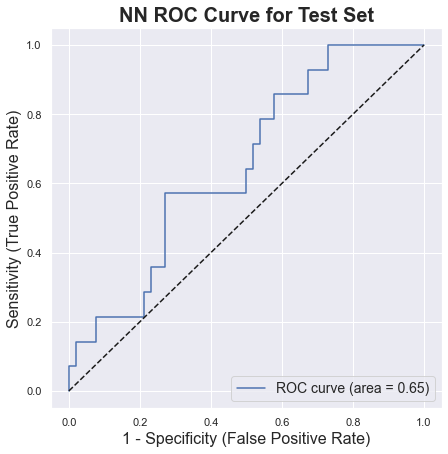

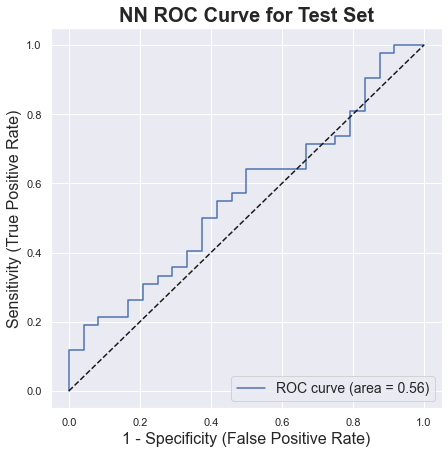

In [297]:
y_score = nn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3]) ##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('NN ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [298]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] 
bootstrapped_npv_scores = [] 

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] 
    one_npv = [] 
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [299]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##